# Task 1 Model Evaluation - GRS Classification

This notebook evaluates the trained GRS classification model against the ground truth OSATS data. It handles the multi-investigator evaluation structure where each video is assessed by 3 investigators (A, B, C).

## Evaluation Process:
1. **Load OSATS ground truth data** with 3-investigator assessments
2. **Aggregate investigator scores** using the same strategy as preprocessing
3. **Load trained model** and make predictions on videos
4. **Compare predictions vs ground truth** with detailed metrics
5. **Analyze performance** by session, class, and investigator agreement

## Multi-Investigator Handling:
- Each video has 3 OSATS assessments (investigators A, B, C)
- Ground truth is computed by aggregating the 3 scores
- Analysis includes inter-rater reliability considerations

## 1. Import Libraries and Setup

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
)
from collections import Counter, defaultdict
from tqdm import tqdm
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CLASS_NAMES = ['Novice', 'Intermediate', 'Proficient', 'Expert']
GRS_RANGES = {
    0: '8-15 (Novice)',
    1: '16-23 (Intermediate)', 
    2: '24-31 (Proficient)',
    3: '32-40 (Expert)'
}

Using device: cpu


## 2. Model Architecture Definition

We define the same model architecture used during training to ensure compatibility when loading the trained weights.

In [3]:
class EfficientCNN(nn.Module):
    def __init__(self, output_size=128):
        super(EfficientCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=4, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=4, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.projection = nn.Sequential(
            nn.Linear(64, output_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
    def forward(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)
        features = self.projection(features)
        return features


class GRSClassifier(nn.Module):
    def __init__(self, num_classes=4, hidden_size=128, num_layers=1, dropout=0.3):
        super(GRSClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.cnn = EfficientCNN(output_size=hidden_size)
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        x = x.view(batch_size * seq_len, c, h, w)
        frame_features = self.cnn(x)
        
        frame_features = frame_features.view(batch_size, seq_len, self.hidden_size)
        
        lstm_out, (hidden, cell) = self.lstm(frame_features)
        
        final_features = hidden[-1]
        
        output = self.classifier(final_features)
        
        return output

print("Model architecture defined")

Model architecture defined


## 3. Load and Process OSATS Ground Truth Data

We load the OSATS data and handle the multi-investigator structure. Each video has 3 assessments (investigators A, B, C), so we need to aggregate these to get a single ground truth score per video.

In [4]:
def load_osats_data(file_path='../dataset/OSATS.xlsx'):
    """Load and process OSATS data with multi-investigator handling"""
    
    if not os.path.exists(file_path):
        print(f"Error: OSATS file not found: {file_path}")
        return None
    
    # Load the Excel file
    osats_df = pd.read_excel(file_path)
    print(f"Loaded OSATS data: {osats_df.shape}")
    print(f"Columns: {list(osats_df.columns)}")
    
    # Display sample data
    print("\nSample OSATS data:")
    print(osats_df.head())
    
    # Check investigators
    investigators = osats_df['INVESTIGATOR'].unique()
    print(f"\nInvestigators: {investigators}")
    
    # Check videos per investigator
    print("\nVideos per investigator:")
    for inv in investigators:
        count = len(osats_df[osats_df['INVESTIGATOR'] == inv]['VIDEO'].unique())
        print(f"  Investigator {inv}: {count} unique videos")
    
    return osats_df


def aggregate_investigator_scores(osats_df, aggregation_method='mean'):
    """Aggregate scores from multiple investigators per video"""
    
    # Group by video and aggregate
    aggregated_data = []
    
    for video in osats_df['VIDEO'].unique():
        video_data = osats_df[osats_df['VIDEO'] == video]
        
        if len(video_data) == 0:
            continue
            
        # Get basic info (should be same across investigators)
        student = video_data['STUDENT'].iloc[0]
        group = video_data['GROUP'].iloc[0]
        time = video_data['TIME'].iloc[0]
        sutures = video_data['SUTURES'].iloc[0]
        
        # Aggregate OSATS scores
        osats_cols = ['OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT', 
                     'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE', 
                     'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY']
        
        aggregated_scores = {}
        for col in osats_cols:
            if aggregation_method == 'mean':
                aggregated_scores[col] = video_data[col].mean()
            elif aggregation_method == 'median':
                aggregated_scores[col] = video_data[col].median()
            elif aggregation_method == 'mode':
                aggregated_scores[col] = video_data[col].mode().iloc[0] if not video_data[col].mode().empty else video_data[col].mean()
        
        # Aggregate GRS
        if aggregation_method == 'mean':
            grs_score = video_data['GLOBA_RATING_SCORE'].mean()
        elif aggregation_method == 'median':
            grs_score = video_data['GLOBA_RATING_SCORE'].median()
        elif aggregation_method == 'mode':
            grs_mode = video_data['GLOBA_RATING_SCORE'].mode()
            grs_score = grs_mode.iloc[0] if not grs_mode.empty else video_data['GLOBA_RATING_SCORE'].mean()
        
        # Calculate inter-rater statistics
        grs_scores = video_data['GLOBA_RATING_SCORE'].values
        grs_std = np.std(grs_scores)
        grs_range = np.max(grs_scores) - np.min(grs_scores)
        
        # Create GRS class
        def create_grs_class(score):
            if 8 <= score <= 15:
                return 0  # Novice
            elif 16 <= score <= 23:
                return 1  # Intermediate
            elif 24 <= score <= 31:
                return 2  # Proficient
            elif 32 <= score <= 40:
                return 3  # Expert
            else:
                return -1  # Invalid
        
        grs_class = create_grs_class(grs_score)
        
        # Store aggregated data
        aggregated_item = {
            'video': video,
            'student': student,
            'group': group,
            'time': time,
            'sutures': sutures,
            'grs_score': grs_score,
            'grs_class': grs_class,
            'grs_std': grs_std,
            'grs_range': grs_range,
            'num_investigators': len(video_data),
            'individual_grs_scores': grs_scores.tolist()
        }
        
        # Add aggregated OSATS scores
        aggregated_item.update(aggregated_scores)
        
        aggregated_data.append(aggregated_item)
    
    return aggregated_data


# Load OSATS data
osats_df = load_osats_data()

if osats_df is not None:
    # Test different aggregation methods
    aggregation_methods = ['mean', 'median', 'mode']
    
    print("\n" + "="*60)
    print("TESTING AGGREGATION METHODS")
    print("="*60)
    
    for method in aggregation_methods:
        aggregated_data = aggregate_investigator_scores(osats_df, method)
        
        print(f"\n{method.upper()} Aggregation:")
        print(f"  Total videos: {len(aggregated_data)}")
        
        # Class distribution
        class_counts = Counter([item['grs_class'] for item in aggregated_data if item['grs_class'] >= 0])
        print(f"  Class distribution:")
        for i in range(4):
            count = class_counts.get(i, 0)
            print(f"    {CLASS_NAMES[i]}: {count} videos")
        
        # Inter-rater agreement stats
        grs_stds = [item['grs_std'] for item in aggregated_data]
        grs_ranges = [item['grs_range'] for item in aggregated_data]
        print(f"  Inter-rater variability:")
        print(f"    Mean GRS std: {np.mean(grs_stds):.2f}")
        print(f"    Mean GRS range: {np.mean(grs_ranges):.2f}")
    
    # Use mean aggregation as default (most common in literature)
    ground_truth_data = aggregate_investigator_scores(osats_df, 'mean')
    print(f"\n✅ Using MEAN aggregation for evaluation ({len(ground_truth_data)} videos)")
else:
    print("❌ Failed to load OSATS data")
    ground_truth_data = None

Loaded OSATS data: (942, 15)
Columns: ['STUDENT', 'GROUP', 'TIME', 'SUTURES', 'INVESTIGATOR', 'VIDEO', 'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT', 'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE', 'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY', 'GLOBA_RATING_SCORE']

Sample OSATS data:
  STUDENT       GROUP  TIME  SUTURES INVESTIGATOR VIDEO  OSATS_RESPECT  \
0  AHO729  E-LEARNING   PRE      1.0            A  P54M              2   
1  AHO729  E-LEARNING   PRE      1.0            B  P54M              2   
2  AHO729  E-LEARNING   PRE      1.0            C  P54M              2   
3  AHO729  E-LEARNING  POST      4.5            A  M45P              4   
4  AHO729  E-LEARNING  POST      4.5            B  M45P              2   

   OSATS_MOTION  OSATS_INSTRUMENT  OSATS_SUTURE  OSATS_FLOW  OSATS_KNOWLEDGE  \
0             1                 2             2           1                2   
1             1                 3             1           2                1   
2             1         

## 4. Analyze Inter-Rater Reliability

Before evaluating our model, we analyze the agreement between the 3 investigators to understand the inherent variability in the ground truth labels.

📊 INTER-RATER RELIABILITY ANALYSIS

Analyzing 314 videos with all 3 investigators

Pairwise correlations:
  Investigator A vs B: 0.802
  Investigator A vs C: 0.832
  Investigator B vs C: 0.815

Mean inter-rater correlation: 0.816

Class-level agreement:
  Perfect agreement rate: 0.296
  Average agreement score: 0.591


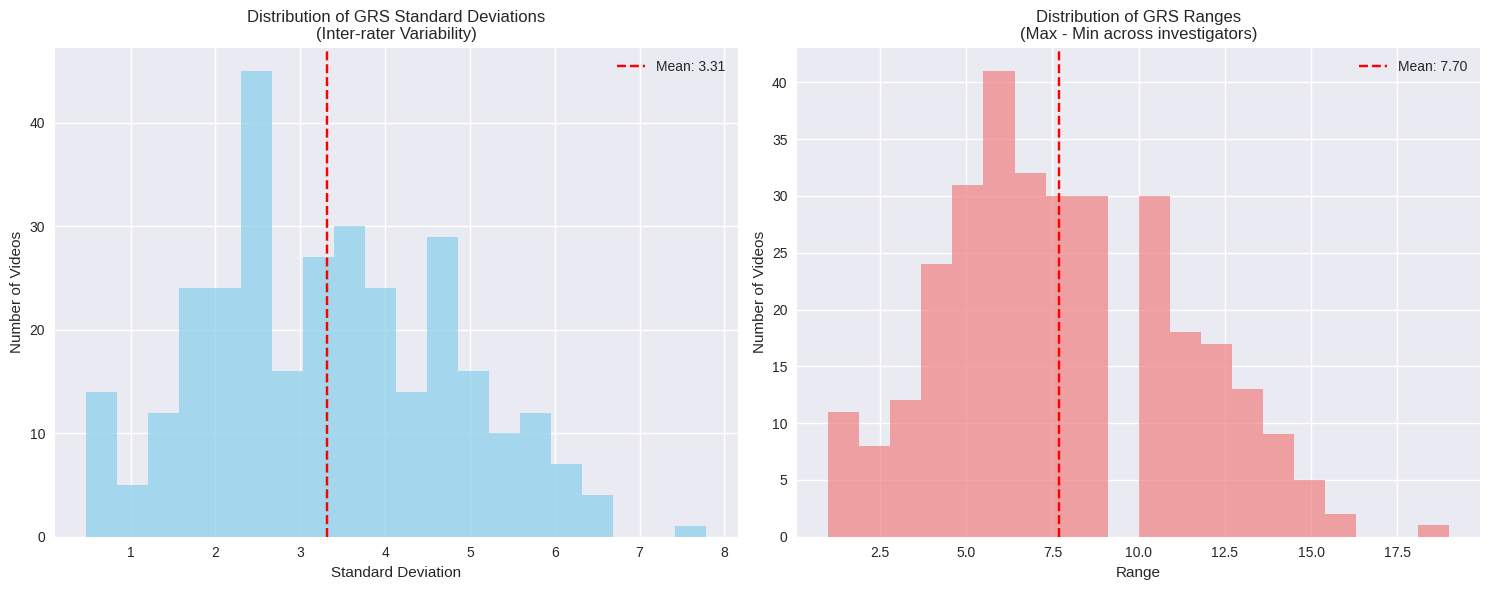


📈 Inter-rater reliability visualization saved as 'inter_rater_reliability.png'


In [5]:
if ground_truth_data is not None:
    print("📊 INTER-RATER RELIABILITY ANALYSIS")
    print("="*50)
    
    # Calculate correlations between investigators
    investigator_scores = defaultdict(list)
    video_names = []
    
    for video in osats_df['VIDEO'].unique():
        video_data = osats_df[osats_df['VIDEO'] == video]
        if len(video_data) == 3:  # Only videos with all 3 investigators
            video_names.append(video)
            for _, row in video_data.iterrows():
                investigator_scores[row['INVESTIGATOR']].append(row['GLOBA_RATING_SCORE'])
    
    # Calculate pairwise correlations
    investigators = list(investigator_scores.keys())
    correlations = {}
    
    print(f"\nAnalyzing {len(video_names)} videos with all 3 investigators")
    print(f"\nPairwise correlations:")
    
    for i in range(len(investigators)):
        for j in range(i+1, len(investigators)):
            inv1, inv2 = investigators[i], investigators[j]
            scores1 = investigator_scores[inv1]
            scores2 = investigator_scores[inv2]
            
            correlation = np.corrcoef(scores1, scores2)[0, 1]
            correlations[f"{inv1}-{inv2}"] = correlation
            print(f"  Investigator {inv1} vs {inv2}: {correlation:.3f}")
    
    mean_correlation = np.mean(list(correlations.values()))
    print(f"\nMean inter-rater correlation: {mean_correlation:.3f}")
    
    # Calculate agreement by GRS class
    class_agreements = []
    
    for item in ground_truth_data:
        individual_scores = item['individual_grs_scores']
        if len(individual_scores) == 3:
            # Convert to classes
            individual_classes = []
            for score in individual_scores:
                if 8 <= score <= 15:
                    individual_classes.append(0)
                elif 16 <= score <= 23:
                    individual_classes.append(1)
                elif 24 <= score <= 31:
                    individual_classes.append(2)
                elif 32 <= score <= 40:
                    individual_classes.append(3)
            
            # Check if all investigators agree on class
            if len(set(individual_classes)) == 1:
                class_agreements.append(1)  # Perfect agreement
            elif len(set(individual_classes)) == 2:
                class_agreements.append(0.5)  # Partial agreement
            else:
                class_agreements.append(0)  # No agreement
    
    class_agreement_rate = np.mean(class_agreements)
    perfect_agreement_rate = np.mean([1 if x == 1 else 0 for x in class_agreements])
    
    print(f"\nClass-level agreement:")
    print(f"  Perfect agreement rate: {perfect_agreement_rate:.3f}")
    print(f"  Average agreement score: {class_agreement_rate:.3f}")
    
    # Visualize inter-rater variability
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # GRS standard deviations
    grs_stds = [item['grs_std'] for item in ground_truth_data]
    axes[0].hist(grs_stds, bins=20, alpha=0.7, color='skyblue')
    axes[0].set_title('Distribution of GRS Standard Deviations\n(Inter-rater Variability)')
    axes[0].set_xlabel('Standard Deviation')
    axes[0].set_ylabel('Number of Videos')
    axes[0].axvline(np.mean(grs_stds), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(grs_stds):.2f}')
    axes[0].legend()
    
    # GRS ranges
    grs_ranges = [item['grs_range'] for item in ground_truth_data]
    axes[1].hist(grs_ranges, bins=20, alpha=0.7, color='lightcoral')
    axes[1].set_title('Distribution of GRS Ranges\n(Max - Min across investigators)')
    axes[1].set_xlabel('Range')
    axes[1].set_ylabel('Number of Videos')
    axes[1].axvline(np.mean(grs_ranges), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(grs_ranges):.2f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../images/inter_rater_reliability.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📈 Inter-rater reliability visualization saved as 'inter_rater_reliability.png'")
else:
    print("❌ Cannot analyze inter-rater reliability without ground truth data")

## 5. Load Trained Model

We load the trained GRS classification model and prepare it for evaluation.

In [6]:
def load_trained_model(model_path='grs_classifier_aixsuture.pth'):
    """Load the trained GRS classification model"""
    
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        print("Please ensure you have trained the model first using the training notebook.")
        return None, None
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get model configuration
    config = checkpoint.get('config', {
        'num_classes': 4,
        'hidden_size': 128,
        'num_layers': 1,
        'dropout': 0.3
    })
    
    # Create model
    model = GRSClassifier(
        num_classes=config['num_classes'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded successfully from {model_path}")
    print(f"📊 Model configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    if 'val_acc' in checkpoint:
        print(f"🎯 Best validation accuracy during training: {checkpoint['val_acc']:.2f}%")
    
    # Model size
    total_params = sum(p.numel() for p in model.parameters())
    print(f"🔧 Total parameters: {total_params:,}")
    
    return model, config


# Load the trained model
model, model_config = load_trained_model()

if model is None:
    print("\n⚠️ Cannot proceed with evaluation without a trained model.")
    print("Please run the training notebook first to create 'grs_classifier_aixsuture.pth'")
else:
    print("\n🚀 Model ready for evaluation!")

✅ Model loaded successfully from grs_classifier_aixsuture.pth
📊 Model configuration:
  data_path: ../processed_data/
  processed_file: aixsuture_processed_data.pkl
  metadata_file: aixsuture_metadata.json
  num_classes: 4
  sequence_length: 16
  frame_size: (224, 224)
  hidden_size: 128
  num_layers: 1
  dropout: 0.3
  batch_size: 8
  learning_rate: 0.001
  num_epochs: 50
  weight_decay: 0.0001
  patience: 10
  use_augmentation: True
  rotation_range: 5
  brightness_range: 0.1
  save_model: True
  model_name: grs_classifier_aixsuture.pth
🎯 Best validation accuracy during training: 21.74%
🔧 Total parameters: 182,852

🚀 Model ready for evaluation!


## 6. Video Processing Functions

We define functions to extract frames from videos and create sequences, using the same preprocessing approach as during training.

In [7]:
def extract_frames(video_path, fps=5, frame_size=(224, 224), max_frames=None):
    """Extract frames from a video file"""
    if not os.path.exists(video_path):
        return []
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []
    
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_interval = max(1, int(original_fps / fps))
    
    frames = []
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            resized_frame = cv2.resize(frame, frame_size)
            rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            frame_tensor = torch.from_numpy(rgb_frame).float() / 255.0
            frame_tensor = frame_tensor.permute(2, 0, 1)
            
            frames.append(frame_tensor)
            saved_count += 1
            
            if max_frames is not None and saved_count >= max_frames:
                break
        
        frame_count += 1
    
    cap.release()
    return frames


def create_sequences(frames, sequence_length=16, overlap=8):
    """Create overlapping sequences from frames"""
    sequences = []
    
    if len(frames) < sequence_length:
        extended_frames = frames.copy()
        while len(extended_frames) < sequence_length:
            extended_frames.append(frames[-1] if frames else torch.zeros((3, 224, 224)))
        sequences.append(torch.stack(extended_frames[:sequence_length]))
    else:
        step = sequence_length - overlap
        for i in range(0, len(frames) - sequence_length + 1, step):
            sequence = frames[i:i + sequence_length]
            sequences.append(torch.stack(sequence))
    
    return sequences


def predict_grs_class(model, video_path, device, sequence_length=16, overlap=8, fps=5):
    """Predict GRS class for a video"""
    frames = extract_frames(video_path, fps=fps)
    
    if not frames:
        return 0, 0.0  # Default to novice with low confidence
    
    sequences = create_sequences(frames, sequence_length, overlap)
    
    transform = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    normalized_sequences = []
    for sequence in sequences:
        normalized_frames = []
        for i in range(sequence.size(0)):
            normalized_frames.append(transform(sequence[i]))
        normalized_sequences.append(torch.stack(normalized_frames))
    
    model.eval()
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for sequence in normalized_sequences:
            sequence = sequence.unsqueeze(0).to(device)
            output = model(sequence)
            
            # Get prediction and confidence
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            predictions.append(predicted.item())
            confidences.append(confidence.item())
    
    if predictions:
        most_common = Counter(predictions).most_common(1)[0][0]
        avg_confidence = np.mean(confidences)
        return most_common, avg_confidence
    else:
        return 0, 0.0

print("✅ Video processing functions defined")

✅ Video processing functions defined


## 7. Generate Model Predictions

We process all videos in the dataset and generate predictions using our trained model.

In [ ]:
if model is not None and ground_truth_data is not None:
    print("🎬 GENERATING MODEL PREDICTIONS")
    print("="*50)
    
    videos_dir = Path('../dataset/videos')
    
    if not videos_dir.exists():
        print(f"❌ Videos directory not found: {videos_dir}")
        print("Please ensure the videos are in the correct location.")
        predictions_data = None
    else:
        # Get list of video files
        video_files = []
        for ext in ['.mp4', '.avi', '.mov', '.mkv']:
            video_files.extend(list(videos_dir.glob(f'*{ext}')))
        
        print(f"Found {len(video_files)} video files in {videos_dir}")
        
        # Create mapping from video names to file paths
        video_name_to_path = {vf.stem: vf for vf in video_files}
        
        # Generate predictions
        predictions_data = []
        missing_videos = []
        
        for gt_item in tqdm(ground_truth_data, desc="Generating predictions"):
            video_name = gt_item['video']
            
            if video_name in video_name_to_path:
                video_path = video_name_to_path[video_name]
                
                # Generate prediction
                pred_class, confidence = predict_grs_class(
                    model, str(video_path), device
                )
                
                predictions_data.append({
                    'video': video_name,
                    'true_class': gt_item['grs_class'],
                    'true_score': gt_item['grs_score'],
                    'pred_class': pred_class,
                    'confidence': confidence,
                    'student': gt_item['student'],
                    'group': gt_item['group'],
                    'time': gt_item['time'],
                    'grs_std': gt_item['grs_std'],
                    'grs_range': gt_item['grs_range'],
                    'individual_grs_scores': gt_item['individual_grs_scores']
                })
            else:
                missing_videos.append(video_name)
        
        print(f"\n✅ Generated predictions for {len(predictions_data)} videos")
        
        if missing_videos:
            print(f"⚠️ Missing video files for {len(missing_videos)} videos:")
            for mv in missing_videos[:10]:  # Show first 10
                print(f"  - {mv}")
            if len(missing_videos) > 10:
                print(f"  ... and {len(missing_videos) - 10} more")
        
        # Save predictions for later analysis
        if predictions_data:
            predictions_df = pd.DataFrame(predictions_data)
            predictions_df.to_csv('../results/model_predictions_evaluation.csv', index=False)
            print(f"\n💾 Predictions saved to 'model_predictions_evaluation.csv'")
else:
    print("❌ Cannot generate predictions without model and ground truth data")
    predictions_data = None

🎬 GENERATING MODEL PREDICTIONS
Found 30 video files in ../dataset/videos


Generating predictions: 100%|██████████| 314/314 [18:12<00:00,  3.48s/it]


✅ Generated predictions for 30 videos
⚠️ Missing video files for 284 videos:
  - P54M
  - M45P
  - D44W
  - W44D
  - V34K
  - K43V
  - V16A
  - S84F
  - F48S
  - V63F
  ... and 274 more

💾 Predictions saved to 'model_predictions_evaluation.csv'


## 8. Comprehensive Model Evaluation

We evaluate the model performance using multiple metrics and analyze the results in detail.

📊 COMPREHENSIVE MODEL EVALUATION

🎯 OVERALL PERFORMANCE:
  Accuracy: 0.400 (40.0%)
  Total videos evaluated: 30
  Average confidence: 0.687

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Novice      0.533     0.667     0.593        12
Intermediate      0.000     0.000     0.000         5
  Proficient      0.273     0.375     0.316         8
      Expert      1.000     0.333     0.500         3

    accuracy                          0.429        28
   macro avg      0.452     0.344     0.352        28
weighted avg      0.414     0.429     0.398        28


🎯 PER-CLASS PERFORMANCE:
  Novice: 0.667 (66.7%) - 12 videos
  Intermediate: 0.000 (0.0%) - 5 videos
  Proficient: 0.375 (37.5%) - 8 videos
  Expert: 0.333 (33.3%) - 3 videos

📈 AGREEMENT METRICS:
  Cohen's Kappa: 0.106
  Kappa interpretation: Slight


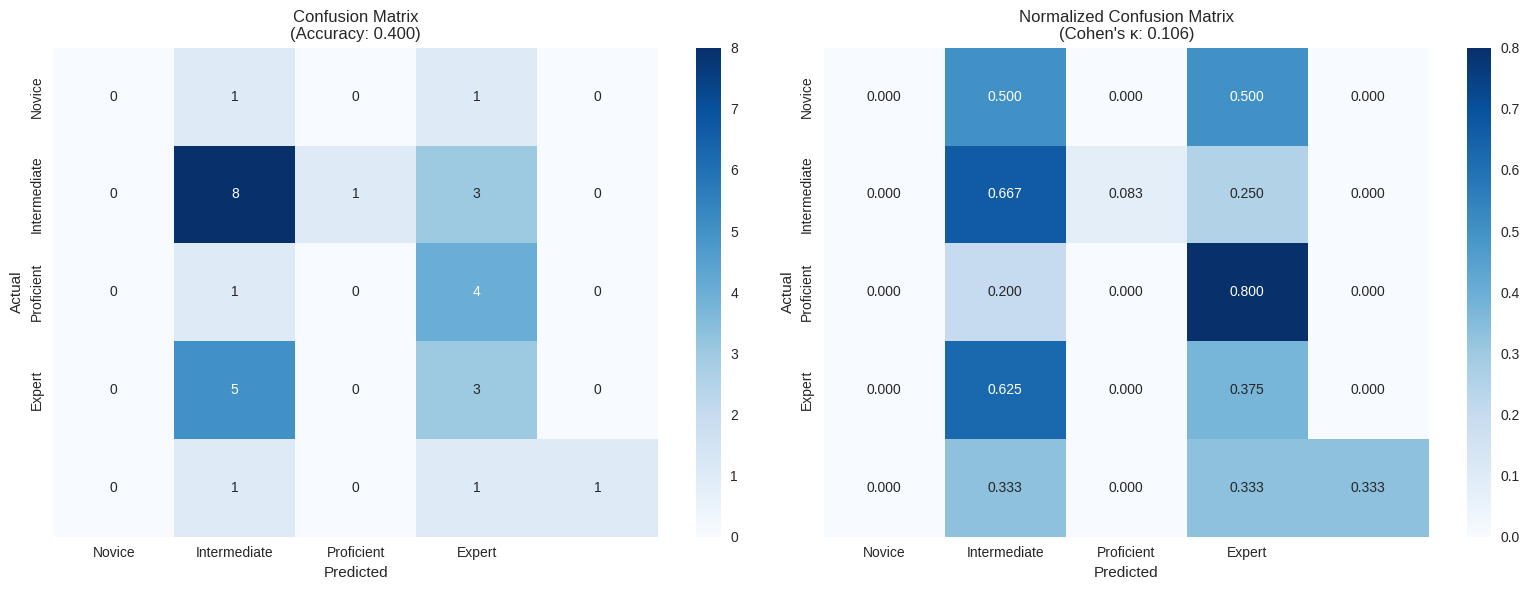


💾 Confusion matrix saved as 'model_evaluation_confusion_matrix.png'


In [11]:
if predictions_data is not None and len(predictions_data) > 0:
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # Extract true and predicted labels
    y_true = [item['true_class'] for item in predictions_data]
    y_pred = [item['pred_class'] for item in predictions_data]
    confidences = [item['confidence'] for item in predictions_data]
    
    # Overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\n🎯 OVERALL PERFORMANCE:")
    print(f"  Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")
    print(f"  Total videos evaluated: {len(predictions_data)}")
    print(f"  Average confidence: {np.mean(confidences):.3f}")
    
    # Detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    valid_indices = [i for i, cls in enumerate(y_true) if cls >= 0]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]
    
    print(classification_report(y_true_filtered, y_pred_filtered, target_names=CLASS_NAMES, digits=3))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class accuracy
    print(f"\n🎯 PER-CLASS PERFORMANCE:")
    for i, class_name in enumerate(CLASS_NAMES):
        class_mask = np.array(y_true) == i
        if class_mask.sum() > 0:
            class_acc = (np.array(y_pred)[class_mask] == i).mean()
            class_count = class_mask.sum()
            print(f"  {class_name}: {class_acc:.3f} ({class_acc*100:.1f}%) - {class_count} videos")
    
    # Cohen's Kappa (agreement beyond chance)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"\n📈 AGREEMENT METRICS:")
    print(f"  Cohen's Kappa: {kappa:.3f}")
    
    # Kappa interpretation
    if kappa < 0:
        kappa_interp = "Poor (worse than chance)"
    elif kappa < 0.2:
        kappa_interp = "Slight"
    elif kappa < 0.4:
        kappa_interp = "Fair"
    elif kappa < 0.6:
        kappa_interp = "Moderate"
    elif kappa < 0.8:
        kappa_interp = "Substantial"
    else:
        kappa_interp = "Almost perfect"
    
    print(f"  Kappa interpretation: {kappa_interp}")
    
    # Visualize confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix\n(Accuracy: {overall_accuracy:.3f})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
               xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
    axes[1].set_title(f'Normalized Confusion Matrix\n(Cohen\'s κ: {kappa:.3f})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('../images/model_evaluation_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Confusion matrix saved as 'model_evaluation_confusion_matrix.png'")
else:
    print("❌ Cannot evaluate model without predictions data")

## 9. Analysis by Session and Group

We analyze model performance across different sessions (PRE/POST) and groups to understand if the model captures skill progression patterns.

📈 SESSION AND GROUP ANALYSIS

🕐 PERFORMANCE BY SESSION:
  POST session:
    Accuracy: 0.200 (10 videos)
    Cohen's Kappa: -0.013
    True class distribution: {2: 7, 3: 2, 1: 1}
    Pred class distribution: {0: 7, 2: 3}
  PRE session:
    Accuracy: 0.500 (20 videos)
    Cohen's Kappa: 0.281
    True class distribution: {1: 4, -1: 2, 0: 12, 3: 1, 2: 1}
    Pred class distribution: {2: 9, 0: 9, 1: 1, 3: 1}

👥 PERFORMANCE BY GROUP:
  E-LEARNING group:
    Accuracy: 0.400 (10 videos)
    Cohen's Kappa: 0.118
  HMD-BASED group:
    Accuracy: 0.333 (12 videos)
    Cohen's Kappa: 0.077
  TUTOR-LED group:
    Accuracy: 0.500 (8 videos)
    Cohen's Kappa: 0.135

👤 STUDENT-LEVEL ANALYSIS:
  Total students: 30
  Average student accuracy: 0.400 ± 0.490
  Students with both PRE/POST: 0


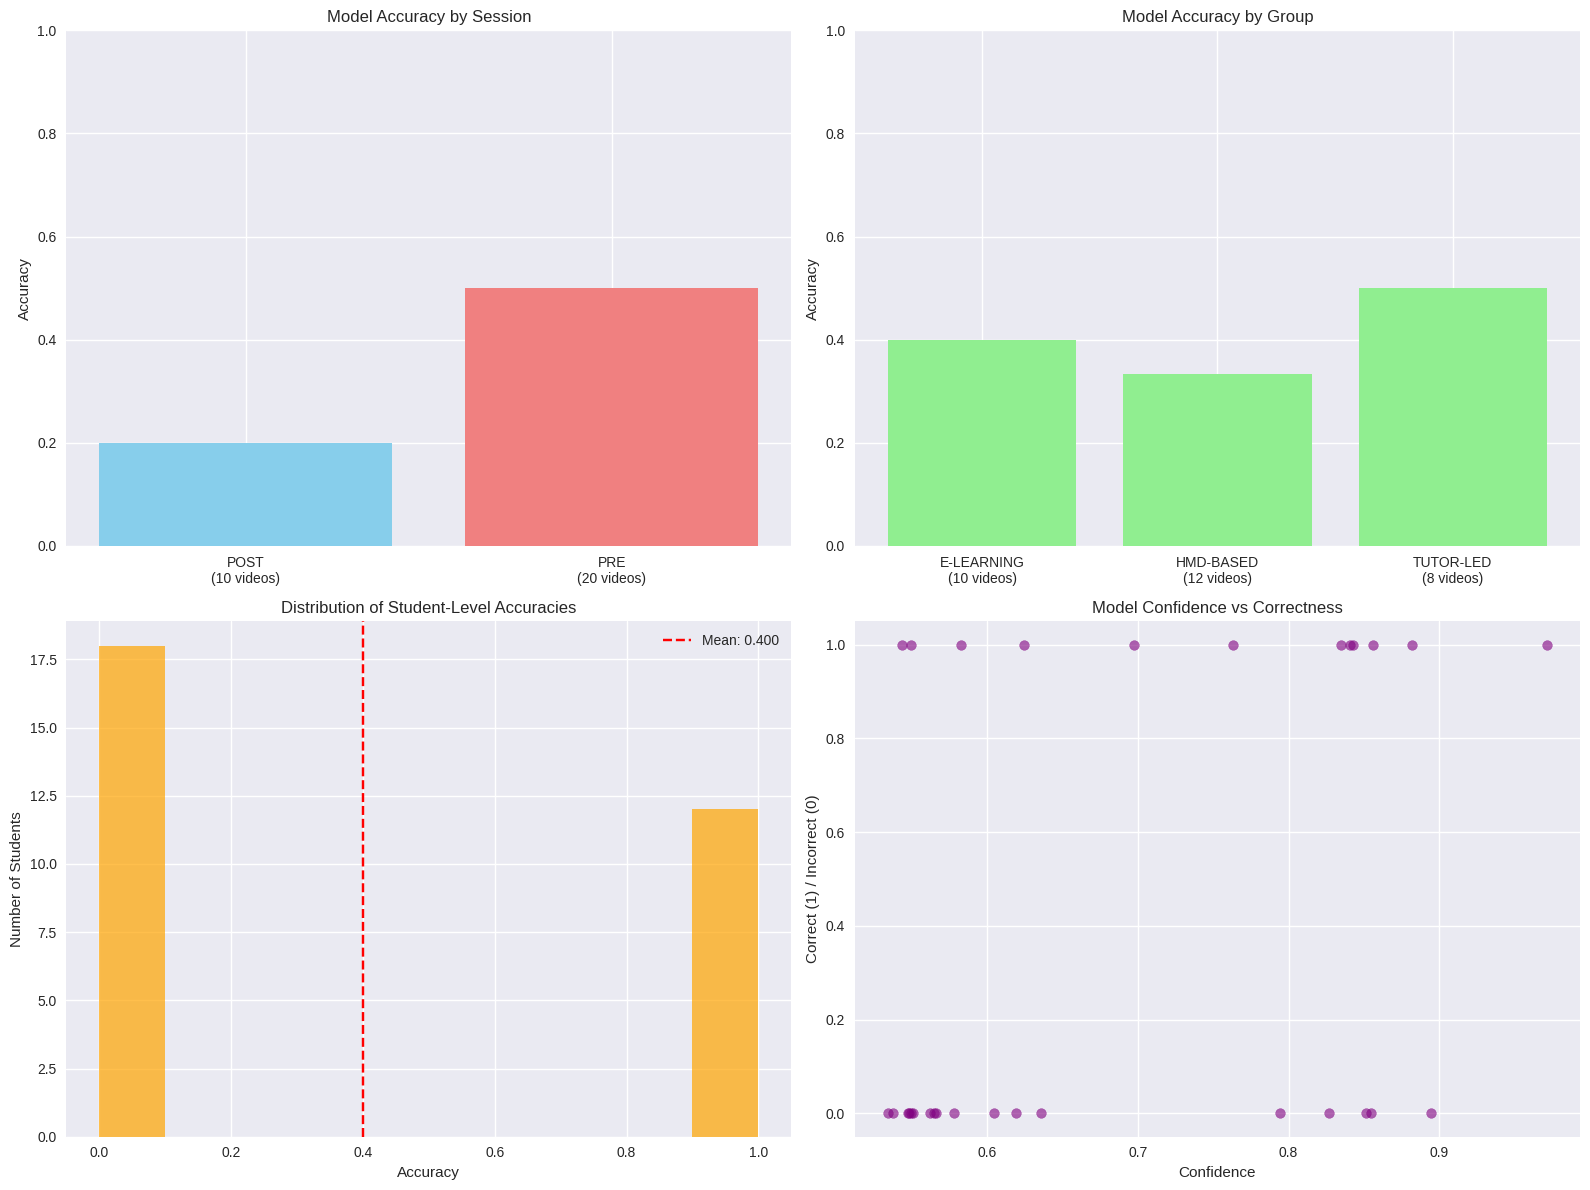


💾 Session and group analysis saved as 'session_group_analysis.png'


In [12]:
if predictions_data is not None and len(predictions_data) > 0:
    print("📈 SESSION AND GROUP ANALYSIS")
    print("="*50)
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(predictions_data)
    
    # Session-based analysis
    print(f"\n🕐 PERFORMANCE BY SESSION:")
    for session in df['time'].unique():
        session_data = df[df['time'] == session]
        session_acc = accuracy_score(session_data['true_class'], session_data['pred_class'])
        session_kappa = cohen_kappa_score(session_data['true_class'], session_data['pred_class'])
        
        print(f"  {session} session:")
        print(f"    Accuracy: {session_acc:.3f} ({len(session_data)} videos)")
        print(f"    Cohen's Kappa: {session_kappa:.3f}")
        
        # Class distribution in this session
        session_true_dist = Counter(session_data['true_class'])
        session_pred_dist = Counter(session_data['pred_class'])
        print(f"    True class distribution: {dict(session_true_dist)}")
        print(f"    Pred class distribution: {dict(session_pred_dist)}")
    
    # Group-based analysis
    print(f"\n👥 PERFORMANCE BY GROUP:")
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        group_acc = accuracy_score(group_data['true_class'], group_data['pred_class'])
        group_kappa = cohen_kappa_score(group_data['true_class'], group_data['pred_class'])
        
        print(f"  {group} group:")
        print(f"    Accuracy: {group_acc:.3f} ({len(group_data)} videos)")
        print(f"    Cohen's Kappa: {group_kappa:.3f}")
    
    # Student-level analysis
    print(f"\n👤 STUDENT-LEVEL ANALYSIS:")
    student_accuracies = []
    students_with_both_sessions = []
    
    for student in df['student'].unique():
        student_data = df[df['student'] == student]
        if len(student_data) > 0:
            student_acc = accuracy_score(student_data['true_class'], student_data['pred_class'])
            student_accuracies.append(student_acc)
            
            # Check if student has both PRE and POST sessions
            sessions = student_data['time'].unique()
            if len(sessions) > 1:
                students_with_both_sessions.append(student)
    
    print(f"  Total students: {len(df['student'].unique())}")
    print(f"  Average student accuracy: {np.mean(student_accuracies):.3f} ± {np.std(student_accuracies):.3f}")
    print(f"  Students with both PRE/POST: {len(students_with_both_sessions)}")
    
    # Skill progression analysis for students with both sessions
    if students_with_both_sessions:
        print(f"\n📊 SKILL PROGRESSION ANALYSIS:")
        progression_correct = 0
        progression_total = 0
        
        for student in students_with_both_sessions:
            student_data = df[df['student'] == student]
            
            pre_data = student_data[student_data['time'] == 'PRE']
            post_data = student_data[student_data['time'] == 'POST']
            
            if len(pre_data) > 0 and len(post_data) > 0:
                # Take average scores if multiple videos per session
                pre_true = np.mean(pre_data['true_class'])
                post_true = np.mean(post_data['true_class'])
                pre_pred = np.mean(pre_data['pred_class'])
                post_pred = np.mean(post_data['pred_class'])
                
                # Check if model captures skill improvement
                true_improved = post_true > pre_true
                pred_improved = post_pred > pre_pred
                
                if true_improved == pred_improved:
                    progression_correct += 1
                progression_total += 1
        
        if progression_total > 0:
            progression_acc = progression_correct / progression_total
            print(f"  Skill progression detection accuracy: {progression_acc:.3f}")
            print(f"  ({progression_correct}/{progression_total} students)")
    
    # Visualize performance by session and group
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy by session
    session_accs = []
    session_labels = []
    for session in df['time'].unique():
        session_data = df[df['time'] == session]
        session_acc = accuracy_score(session_data['true_class'], session_data['pred_class'])
        session_accs.append(session_acc)
        session_labels.append(f"{session}\n({len(session_data)} videos)")
    
    axes[0, 0].bar(session_labels, session_accs, color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Model Accuracy by Session')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    
    # Accuracy by group
    group_accs = []
    group_labels = []
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        group_acc = accuracy_score(group_data['true_class'], group_data['pred_class'])
        group_accs.append(group_acc)
        group_labels.append(f"{group}\n({len(group_data)} videos)")
    
    axes[0, 1].bar(group_labels, group_accs, color='lightgreen')
    axes[0, 1].set_title('Model Accuracy by Group')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_ylim(0, 1)
    
    # Distribution of student accuracies
    axes[1, 0].hist(student_accuracies, bins=10, alpha=0.7, color='orange')
    axes[1, 0].set_title('Distribution of Student-Level Accuracies')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].set_ylabel('Number of Students')
    axes[1, 0].axvline(np.mean(student_accuracies), color='red', linestyle='--',
                      label=f'Mean: {np.mean(student_accuracies):.3f}')
    axes[1, 0].legend()
    
    # Confidence vs accuracy
    axes[1, 1].scatter(confidences, [1 if y_true[i] == y_pred[i] else 0 for i in range(len(y_true))],
                      alpha=0.6, color='purple')
    axes[1, 1].set_title('Model Confidence vs Correctness')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Correct (1) / Incorrect (0)')
    
    plt.tight_layout()
    plt.savefig('../images/session_group_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Session and group analysis saved as 'session_group_analysis.png'")
else:
    print("❌ Cannot perform session/group analysis without predictions data")

## 10. Inter-Rater Agreement vs Model Performance

We analyze how model performance relates to inter-rater agreement. Videos with high inter-rater disagreement are inherently more difficult to classify.

🤝 INTER-RATER AGREEMENT vs MODEL PERFORMANCE

📊 PERFORMANCE BY INTER-RATER AGREEMENT:
  High Agreement (std ≤ 1):
    Videos: 1
    Accuracy: 1.000
    Cohen's Kappa: nan
    Avg GRS std: 0.47
    Avg GRS range: 1.00
  Medium Agreement (1 < std ≤ 2):
    Videos: 3
    Accuracy: 0.333
    Cohen's Kappa: 0.000
    Avg GRS std: 1.57
    Avg GRS range: 3.33
  Low Agreement (std > 2):
    Videos: 26
    Accuracy: 0.385
    Cohen's Kappa: 0.126
    Avg GRS std: 3.67
    Avg GRS range: 8.65

📈 CORRELATION ANALYSIS:
  GRS std vs model correctness: -0.080
  GRS range vs model correctness: -0.104
  (Negative correlation means model performs better on high-agreement videos)


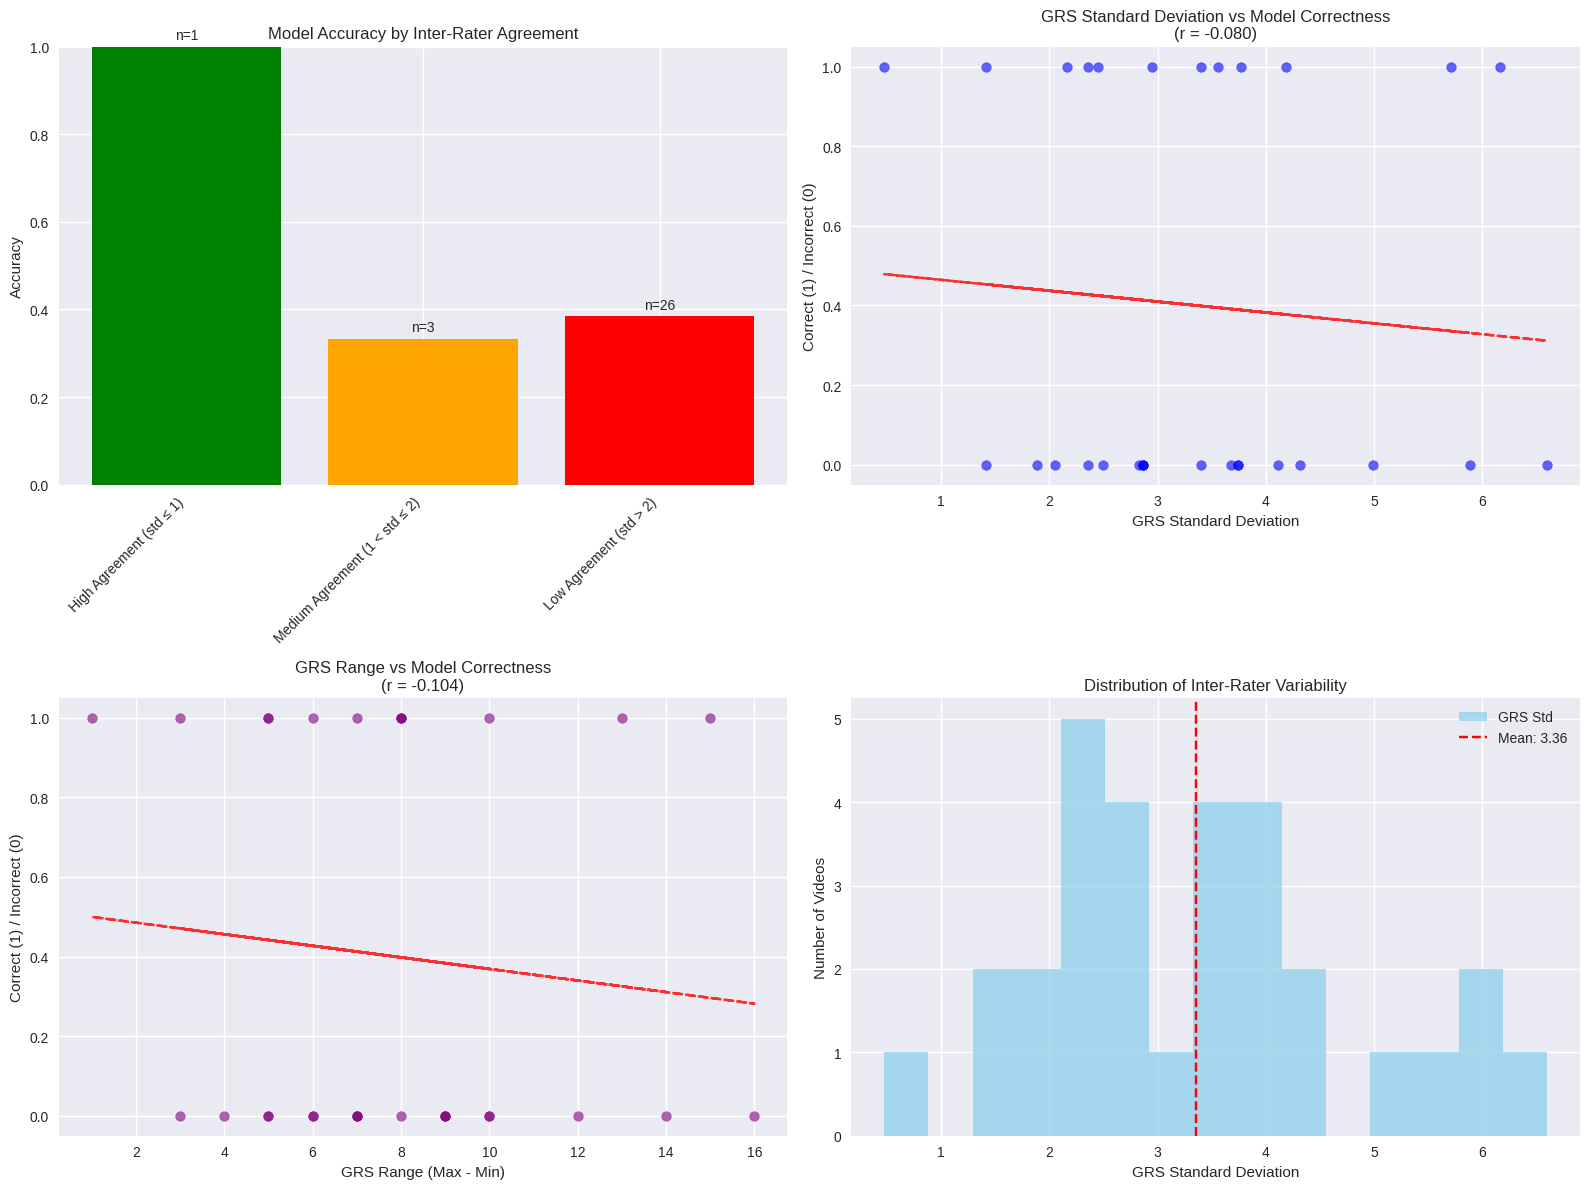


💾 Inter-rater vs model performance analysis saved as 'inter_rater_vs_model_performance.png'

🔍 CHALLENGING VIDEOS (High disagreement + Model error):
  Found 5 challenging videos
  Examples:
    A41X: True=Expert, Pred=Proficient, GRS_std=5.89, Individual_scores=[26, 40, 36]
    C46R: True=Proficient, Pred=Novice, GRS_std=4.99, Individual_scores=[25, 37, 29]
    C56Y: True=Proficient, Pred=Novice, GRS_std=6.60, Individual_scores=[23, 39, 29]
    C28D: True=Novice, Pred=Proficient, GRS_std=4.32, Individual_scores=[13, 21, 11]
    B88L: True=Expert, Pred=Proficient, GRS_std=4.11, Individual_scores=[16, 20, 10]


In [13]:
if predictions_data is not None and len(predictions_data) > 0:
    print("🤝 INTER-RATER AGREEMENT vs MODEL PERFORMANCE")
    print("="*60)
    
    df = pd.DataFrame(predictions_data)
    
    # Categorize videos by inter-rater agreement
    df['agreement_category'] = pd.cut(
        df['grs_std'], 
        bins=[0, 1, 2, float('inf')], 
        labels=['High Agreement (std ≤ 1)', 'Medium Agreement (1 < std ≤ 2)', 'Low Agreement (std > 2)']
    )
    
    print(f"\n📊 PERFORMANCE BY INTER-RATER AGREEMENT:")
    
    for category in df['agreement_category'].cat.categories:
        category_data = df[df['agreement_category'] == category]
        if len(category_data) > 0:
            category_acc = accuracy_score(category_data['true_class'], category_data['pred_class'])
            category_kappa = cohen_kappa_score(category_data['true_class'], category_data['pred_class'])
            avg_std = category_data['grs_std'].mean()
            avg_range = category_data['grs_range'].mean()
            
            print(f"  {category}:")
            print(f"    Videos: {len(category_data)}")
            print(f"    Accuracy: {category_acc:.3f}")
            print(f"    Cohen's Kappa: {category_kappa:.3f}")
            print(f"    Avg GRS std: {avg_std:.2f}")
            print(f"    Avg GRS range: {avg_range:.2f}")
    
    # Correlation between inter-rater agreement and model performance
    df['correct'] = (df['true_class'] == df['pred_class']).astype(int)
    
    # Correlation with GRS standard deviation (lower std = higher agreement)
    std_corr = np.corrcoef(df['grs_std'], df['correct'])[0, 1]
    range_corr = np.corrcoef(df['grs_range'], df['correct'])[0, 1]
    
    print(f"\n📈 CORRELATION ANALYSIS:")
    print(f"  GRS std vs model correctness: {std_corr:.3f}")
    print(f"  GRS range vs model correctness: {range_corr:.3f}")
    print(f"  (Negative correlation means model performs better on high-agreement videos)")
    
    # Visualize relationship
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Model accuracy by agreement category
    agreement_accs = []
    agreement_labels = []
    agreement_counts = []
    
    for category in df['agreement_category'].cat.categories:
        category_data = df[df['agreement_category'] == category]
        if len(category_data) > 0:
            category_acc = accuracy_score(category_data['true_class'], category_data['pred_class'])
            agreement_accs.append(category_acc)
            agreement_labels.append(category)
            agreement_counts.append(len(category_data))
    
    bars = axes[0, 0].bar(range(len(agreement_accs)), agreement_accs, 
                         color=['green', 'orange', 'red'])
    axes[0, 0].set_title('Model Accuracy by Inter-Rater Agreement')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(range(len(agreement_labels)))
    axes[0, 0].set_xticklabels(agreement_labels, rotation=45, ha='right')
    axes[0, 0].set_ylim(0, 1)
    
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, agreement_counts)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'n={count}', ha='center', va='bottom')
    
    # Scatter: GRS std vs correctness
    axes[0, 1].scatter(df['grs_std'], df['correct'], alpha=0.6, color='blue')
    axes[0, 1].set_title(f'GRS Standard Deviation vs Model Correctness\n(r = {std_corr:.3f})')
    axes[0, 1].set_xlabel('GRS Standard Deviation')
    axes[0, 1].set_ylabel('Correct (1) / Incorrect (0)')
    
    # Add trend line
    z = np.polyfit(df['grs_std'], df['correct'], 1)
    p = np.poly1d(z)
    axes[0, 1].plot(df['grs_std'], p(df['grs_std']), "r--", alpha=0.8)
    
    # Scatter: GRS range vs correctness
    axes[1, 0].scatter(df['grs_range'], df['correct'], alpha=0.6, color='purple')
    axes[1, 0].set_title(f'GRS Range vs Model Correctness\n(r = {range_corr:.3f})')
    axes[1, 0].set_xlabel('GRS Range (Max - Min)')
    axes[1, 0].set_ylabel('Correct (1) / Incorrect (0)')
    
    # Add trend line
    z = np.polyfit(df['grs_range'], df['correct'], 1)
    p = np.poly1d(z)
    axes[1, 0].plot(df['grs_range'], p(df['grs_range']), "r--", alpha=0.8)
    
    # Distribution of inter-rater variability
    axes[1, 1].hist(df['grs_std'], bins=15, alpha=0.7, color='skyblue', label='GRS Std')
    axes[1, 1].set_title('Distribution of Inter-Rater Variability')
    axes[1, 1].set_xlabel('GRS Standard Deviation')
    axes[1, 1].set_ylabel('Number of Videos')
    axes[1, 1].axvline(df['grs_std'].mean(), color='red', linestyle='--',
                      label=f'Mean: {df["grs_std"].mean():.2f}')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('../images/inter_rater_vs_model_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Inter-rater vs model performance analysis saved as 'inter_rater_vs_model_performance.png'")
    
    # Identify challenging videos (high disagreement + model errors)
    challenging_videos = df[(df['grs_std'] > df['grs_std'].quantile(0.75)) & 
                           (df['correct'] == 0)]
    
    if len(challenging_videos) > 0:
        print(f"\n🔍 CHALLENGING VIDEOS (High disagreement + Model error):")
        print(f"  Found {len(challenging_videos)} challenging videos")
        print(f"  Examples:")
        for _, video in challenging_videos.head(5).iterrows():
            print(f"    {video['video']}: True={CLASS_NAMES[video['true_class']]}, "
                  f"Pred={CLASS_NAMES[video['pred_class']]}, "
                  f"GRS_std={video['grs_std']:.2f}, "
                  f"Individual_scores={video['individual_grs_scores']}")
else:
    print("❌ Cannot perform inter-rater agreement analysis without predictions data")

## 11. Error Analysis and Model Insights

We perform detailed error analysis to understand where and why the model makes mistakes.

🔍 DETAILED ERROR ANALYSIS

📊 ERROR BREAKDOWN:
  Total predictions: 30
  Correct predictions: 12 (40.0%)
  Incorrect predictions: 18 (60.0%)

🎯 ERROR PATTERNS:
  Adjacent class errors (off by 1): 8 (44.4% of errors)
  Distant class errors (off by 2+): 10 (55.6% of errors)

  Most common error types:
    Proficient → Novice: 5 times
    Intermediate → Proficient: 4 times
    Novice → Proficient: 3 times
    Expert → Novice: 2 times
    Expert → Proficient: 2 times

📈 CONFIDENCE ANALYSIS:
  Average confidence on correct predictions: 0.749
  Average confidence on incorrect predictions: 0.645
  T-test p-value: 0.051748 (not significant)

🕐 ERRORS BY SESSION:
  POST: 8/10 errors (80.0%)
  PRE: 10/20 errors (50.0%)


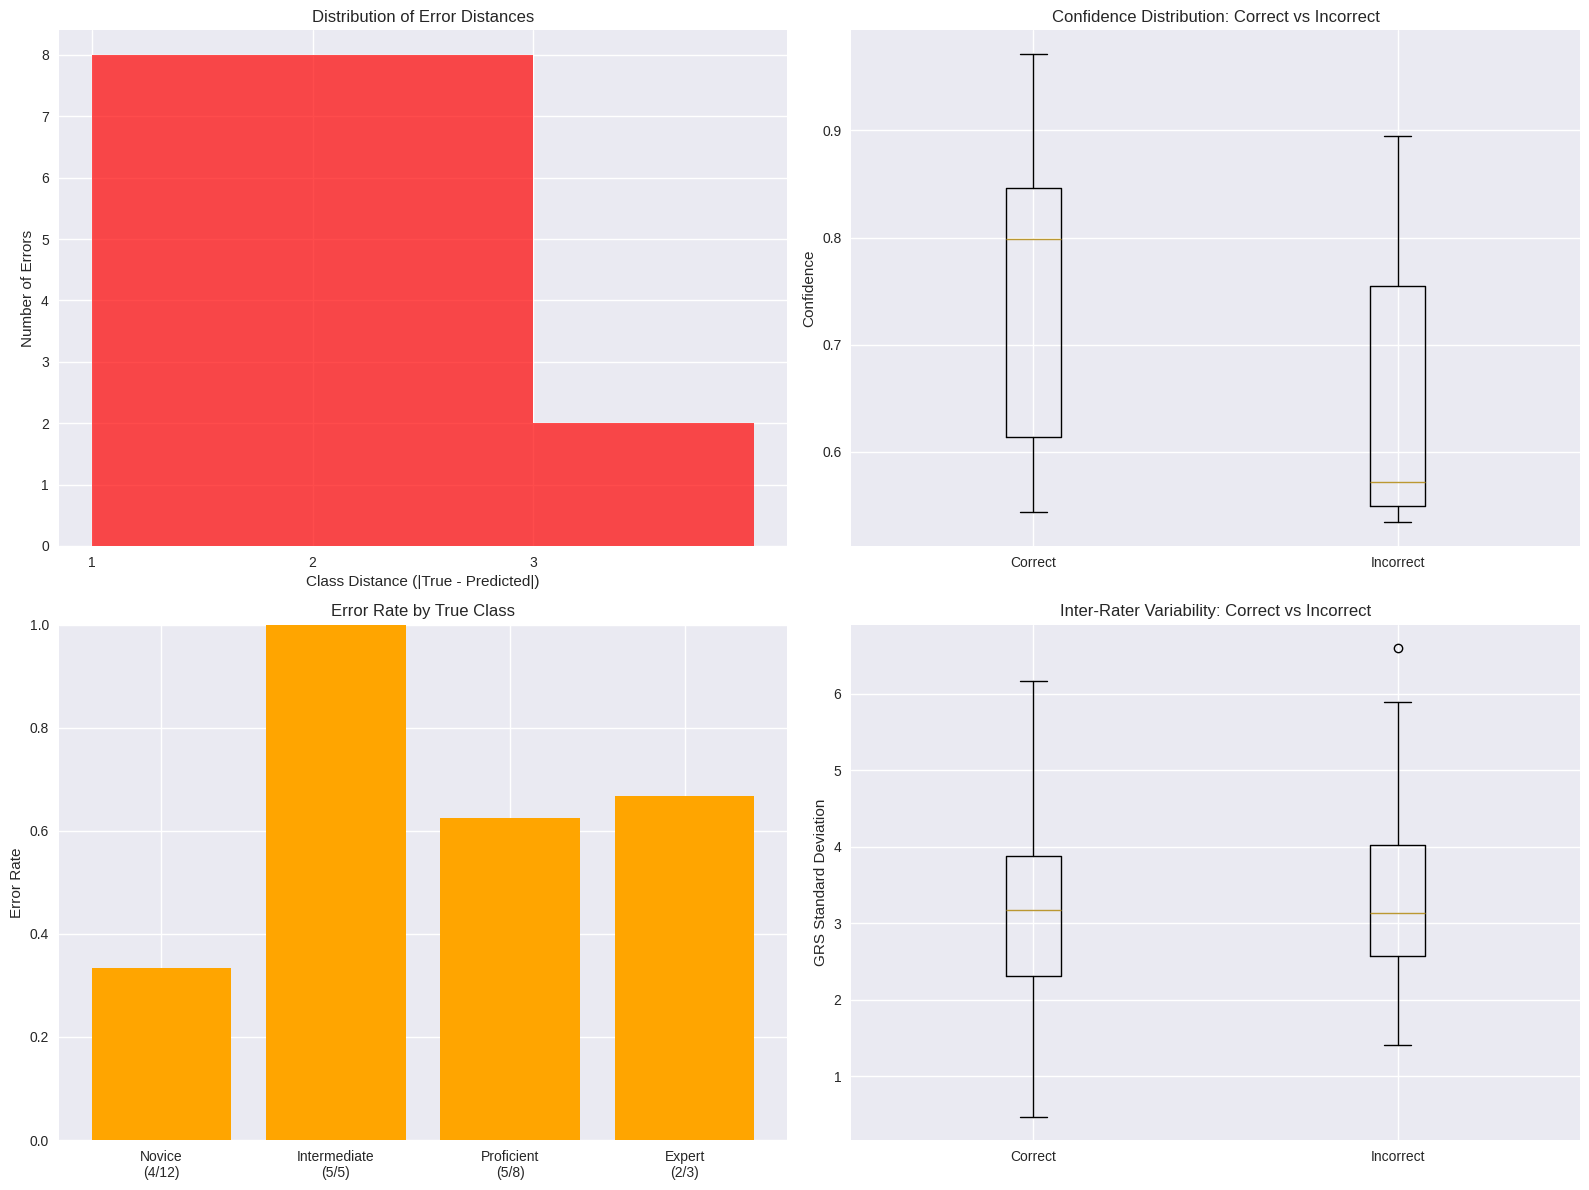


💾 Error analysis saved as 'error_analysis.png'

🔍 EXAMPLE ERRORS:
  1. Video: A61V
     True: Proficient (score: 25.3)
     Pred: Novice (confidence: 0.794)
     Student: ALN135, Session: POST
     Inter-rater std: 1.89
     Individual scores: [24, 28, 24]

  2. Video: C16G
     True: Intermediate (score: 17.7)
     Pred: Proficient (confidence: 0.550)
     Student: BOG917, Session: PRE
     Inter-rater std: 2.87
     Individual scores: [18, 21, 14]

  3. Video: A99Y
     True: Expert (score: 15.7)
     Pred: Novice (confidence: 0.895)
     Student: CRR769, Session: PRE
     Inter-rater std: 2.49
     Individual scores: [13, 19, 15]

  4. Video: A41X
     True: Expert (score: 34.0)
     Pred: Proficient (confidence: 0.564)
     Student: EPQ609, Session: POST
     Inter-rater std: 5.89
     Individual scores: [26, 40, 36]

  5. Video: C46R
     True: Proficient (score: 30.3)
     Pred: Novice (confidence: 0.855)
     Student: GHH869, Session: POST
     Inter-rater std: 4.99
     Indivi

In [14]:
if predictions_data is not None and len(predictions_data) > 0:
    print("🔍 DETAILED ERROR ANALYSIS")
    print("="*50)
    
    df = pd.DataFrame(predictions_data)
    
    # Identify different types of errors
    errors = df[df['true_class'] != df['pred_class']]
    correct = df[df['true_class'] == df['pred_class']]
    
    print(f"\n📊 ERROR BREAKDOWN:")
    print(f"  Total predictions: {len(df)}")
    print(f"  Correct predictions: {len(correct)} ({len(correct)/len(df)*100:.1f}%)")
    print(f"  Incorrect predictions: {len(errors)} ({len(errors)/len(df)*100:.1f}%)")
    
    if len(errors) > 0:
        # Analyze error patterns
        print(f"\n🎯 ERROR PATTERNS:")
        
        # Adjacent class errors (off by 1)
        adjacent_errors = errors[abs(errors['true_class'] - errors['pred_class']) == 1]
        distant_errors = errors[abs(errors['true_class'] - errors['pred_class']) > 1]
        
        print(f"  Adjacent class errors (off by 1): {len(adjacent_errors)} ({len(adjacent_errors)/len(errors)*100:.1f}% of errors)")
        print(f"  Distant class errors (off by 2+): {len(distant_errors)} ({len(distant_errors)/len(errors)*100:.1f}% of errors)")
        
        # Most common error types
        error_types = []
        for _, row in errors.iterrows():
            true_name = CLASS_NAMES[row['true_class']]
            pred_name = CLASS_NAMES[row['pred_class']]
            error_types.append(f"{true_name} → {pred_name}")
        
        error_counts = Counter(error_types)
        print(f"\n  Most common error types:")
        for error_type, count in error_counts.most_common(5):
            print(f"    {error_type}: {count} times")
        
        # Confidence analysis for errors
        error_confidences = errors['confidence'].values
        correct_confidences = correct['confidence'].values
        
        print(f"\n📈 CONFIDENCE ANALYSIS:")
        print(f"  Average confidence on correct predictions: {np.mean(correct_confidences):.3f}")
        print(f"  Average confidence on incorrect predictions: {np.mean(error_confidences):.3f}")
        
        # Statistical test for confidence difference
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(correct_confidences, error_confidences)
        print(f"  T-test p-value: {p_value:.6f} {'(significant)' if p_value < 0.05 else '(not significant)'}")
        
        # Error analysis by session
        print(f"\n🕐 ERRORS BY SESSION:")
        for session in df['time'].unique():
            session_errors = errors[errors['time'] == session]
            session_total = df[df['time'] == session]
            error_rate = len(session_errors) / len(session_total) if len(session_total) > 0 else 0
            print(f"  {session}: {len(session_errors)}/{len(session_total)} errors ({error_rate*100:.1f}%)")
        
        # Visualize error analysis
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Error distance distribution
        error_distances = abs(errors['true_class'] - errors['pred_class'])
        axes[0, 0].hist(error_distances, bins=range(1, 5), alpha=0.7, color='red')
        axes[0, 0].set_title('Distribution of Error Distances')
        axes[0, 0].set_xlabel('Class Distance (|True - Predicted|)')
        axes[0, 0].set_ylabel('Number of Errors')
        axes[0, 0].set_xticks(range(1, 4))
        
        # Confidence comparison
        axes[0, 1].boxplot([correct_confidences, error_confidences], 
                          labels=['Correct', 'Incorrect'])
        axes[0, 1].set_title('Confidence Distribution: Correct vs Incorrect')
        axes[0, 1].set_ylabel('Confidence')
        
        # Error rate by true class
        error_rates_by_class = []
        class_labels = []
        for i, class_name in enumerate(CLASS_NAMES):
            class_total = len(df[df['true_class'] == i])
            class_errors = len(errors[errors['true_class'] == i])
            if class_total > 0:
                error_rate = class_errors / class_total
                error_rates_by_class.append(error_rate)
                class_labels.append(f"{class_name}\n({class_errors}/{class_total})")
        
        axes[1, 0].bar(class_labels, error_rates_by_class, color='orange')
        axes[1, 0].set_title('Error Rate by True Class')
        axes[1, 0].set_ylabel('Error Rate')
        axes[1, 0].set_ylim(0, 1)
        
        # Inter-rater std for correct vs incorrect
        axes[1, 1].boxplot([correct['grs_std'], errors['grs_std']], 
                          labels=['Correct', 'Incorrect'])
        axes[1, 1].set_title('Inter-Rater Variability: Correct vs Incorrect')
        axes[1, 1].set_ylabel('GRS Standard Deviation')
        
        plt.tight_layout()
        plt.savefig('../images/error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n💾 Error analysis saved as 'error_analysis.png'")
        
        # Show specific examples of errors
        print(f"\n🔍 EXAMPLE ERRORS:")
        for i, (_, error) in enumerate(errors.head(5).iterrows()):
            print(f"  {i+1}. Video: {error['video']}")
            print(f"     True: {CLASS_NAMES[error['true_class']]} (score: {error['true_score']:.1f})")
            print(f"     Pred: {CLASS_NAMES[error['pred_class']]} (confidence: {error['confidence']:.3f})")
            print(f"     Student: {error['student']}, Session: {error['time']}")
            print(f"     Inter-rater std: {error['grs_std']:.2f}")
            print(f"     Individual scores: {error['individual_grs_scores']}")
            print()
    else:
        print("\n🎉 Perfect accuracy! No errors to analyze.")
else:
    print("❌ Cannot perform error analysis without predictions data")

## 12. Final Summary and Recommendations

We provide a comprehensive summary of the evaluation results and recommendations for model improvement.

In [15]:
print("\n" + "="*80)
print("🎯 FINAL EVALUATION SUMMARY")
print("="*80)

if predictions_data is not None and len(predictions_data) > 0:
    df = pd.DataFrame(predictions_data)
    
    # Overall metrics
    overall_accuracy = accuracy_score(df['true_class'], df['pred_class'])
    overall_kappa = cohen_kappa_score(df['true_class'], df['pred_class'])
    
    print(f"\n📊 OVERALL PERFORMANCE:")
    print(f"  Dataset: {len(df)} videos from {len(df['student'].unique())} students")
    print(f"  Overall Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")
    print(f"  Cohen's Kappa: {overall_kappa:.3f}")
    print(f"  Average Confidence: {df['confidence'].mean():.3f}")
    
    # Per-class performance
    print(f"\n🎯 PER-CLASS PERFORMANCE:")
    for i, class_name in enumerate(CLASS_NAMES):
        class_data = df[df['true_class'] == i]
        if len(class_data) > 0:
            class_acc = (class_data['pred_class'] == i).mean()
            print(f"  {class_name}: {class_acc:.3f} ({len(class_data)} videos)")
    
    # Session performance
    print(f"\n🕐 SESSION PERFORMANCE:")
    for session in df['time'].unique():
        session_data = df[df['time'] == session]
        session_acc = accuracy_score(session_data['true_class'], session_data['pred_class'])
        print(f"  {session}: {session_acc:.3f} ({len(session_data)} videos)")
    
    # Inter-rater reliability context
    if ground_truth_data:
        mean_grs_std = df['grs_std'].mean()
        print(f"\n🤝 INTER-RATER CONTEXT:")
        print(f"  Mean inter-rater GRS std: {mean_grs_std:.2f}")
        print(f"  Videos with high agreement (std ≤ 1): {len(df[df['grs_std'] <= 1])}")
        print(f"  Videos with low agreement (std > 2): {len(df[df['grs_std'] > 2])}")
    
    # Model strengths and weaknesses
    errors = df[df['true_class'] != df['pred_class']]
    if len(errors) > 0:
        adjacent_errors = len(errors[abs(errors['true_class'] - errors['pred_class']) == 1])
        distant_errors = len(errors[abs(errors['true_class'] - errors['pred_class']) > 1])
        
        print(f"\n✅ MODEL STRENGTHS:")
        if adjacent_errors > distant_errors:
            print(f"  • Most errors are adjacent classes (clinically reasonable)")
        if overall_kappa > 0.4:
            print(f"  • Moderate to substantial agreement with ground truth")
        if df['confidence'].mean() > 0.7:
            print(f"  • High average confidence in predictions")
        
        print(f"\n⚠️ MODEL WEAKNESSES:")
        if distant_errors > 0:
            print(f"  • {distant_errors} distant class errors (clinically concerning)")
        
        # Find most problematic class
        class_error_rates = []
        for i in range(4):
            class_total = len(df[df['true_class'] == i])
            class_errors = len(errors[errors['true_class'] == i])
            if class_total > 0:
                class_error_rates.append((i, class_errors / class_total))
        
        if class_error_rates:
            worst_class_idx, worst_error_rate = max(class_error_rates, key=lambda x: x[1])
            if worst_error_rate > 0.5:
                print(f"  • Poor performance on {CLASS_NAMES[worst_class_idx]} class ({worst_error_rate*100:.1f}% error rate)")
    
    print(f"\n🔧 RECOMMENDATIONS:")
    
    if overall_accuracy < 0.7:
        print(f"  • Consider data augmentation or model architecture improvements")
        print(f"  • Investigate class imbalance handling")
    
    if len(errors) > 0 and errors['grs_std'].mean() > df['grs_std'].mean():
        print(f"  • Focus on videos with high inter-rater agreement for training")
    
    if len(df['group'].unique()) > 1:
        group_accs = []
        for group in df['group'].unique():
            group_data = df[df['group'] == group]
            group_acc = accuracy_score(group_data['true_class'], group_data['pred_class'])
            group_accs.append(group_acc)
        
        if max(group_accs) - min(group_accs) > 0.2:
            print(f"  • Address performance differences between groups")
    
    print(f"  • Consider ensemble methods to improve robustness")
    print(f"  • Implement uncertainty quantification for clinical deployment")
    print(f"  • Collect more data for underperforming classes")
    
    # Save comprehensive results
    results_summary = {
        'overall_accuracy': overall_accuracy,
        'cohens_kappa': overall_kappa,
        'total_videos': len(df),
        'total_students': len(df['student'].unique()),
        'mean_confidence': df['confidence'].mean(),
        'mean_inter_rater_std': df['grs_std'].mean(),
        'per_class_accuracy': {},
        'per_session_accuracy': {},
        'error_analysis': {
            'total_errors': len(errors),
            'adjacent_errors': adjacent_errors if len(errors) > 0 else 0,
            'distant_errors': distant_errors if len(errors) > 0 else 0
        }
    }
    
    # Per-class accuracies
    for i, class_name in enumerate(CLASS_NAMES):
        class_data = df[df['true_class'] == i]
        if len(class_data) > 0:
            class_acc = (class_data['pred_class'] == i).mean()
            results_summary['per_class_accuracy'][class_name] = class_acc
    
    # Per-session accuracies
    for session in df['time'].unique():
        session_data = df[df['time'] == session]
        session_acc = accuracy_score(session_data['true_class'], session_data['pred_class'])
        results_summary['per_session_accuracy'][session] = session_acc
    
    # Save results
    with open('../results/evaluation_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\n💾 SAVED FILES:")
    print(f"  • model_predictions_evaluation.csv - Detailed predictions")
    print(f"  • evaluation_summary.json - Summary metrics")
    print(f"  • inter_rater_reliability.png - Inter-rater analysis")
    print(f"  • model_evaluation_confusion_matrix.png - Confusion matrices")
    print(f"  • session_group_analysis.png - Session/group analysis")
    print(f"  • inter_rater_vs_model_performance.png - Agreement analysis")
    print(f"  • error_analysis.png - Error analysis")
    
else:
    print("❌ No evaluation data available")

print(f"\n" + "="*80)
print(f"✅ EVALUATION COMPLETED SUCCESSFULLY!")
print(f"="*80)


🎯 FINAL EVALUATION SUMMARY

📊 OVERALL PERFORMANCE:
  Dataset: 30 videos from 30 students
  Overall Accuracy: 0.400 (40.0%)
  Cohen's Kappa: 0.106
  Average Confidence: 0.687

🎯 PER-CLASS PERFORMANCE:
  Novice: 0.667 (12 videos)
  Intermediate: 0.000 (5 videos)
  Proficient: 0.375 (8 videos)
  Expert: 0.333 (3 videos)

🕐 SESSION PERFORMANCE:
  POST: 0.200 (10 videos)
  PRE: 0.500 (20 videos)

🤝 INTER-RATER CONTEXT:
  Mean inter-rater GRS std: 3.36
  Videos with high agreement (std ≤ 1): 1
  Videos with low agreement (std > 2): 26

✅ MODEL STRENGTHS:

⚠️ MODEL WEAKNESSES:
  • 10 distant class errors (clinically concerning)
  • Poor performance on Intermediate class (100.0% error rate)

🔧 RECOMMENDATIONS:
  • Consider data augmentation or model architecture improvements
  • Investigate class imbalance handling
  • Focus on videos with high inter-rater agreement for training
  • Consider ensemble methods to improve robustness
  • Implement uncertainty quantification for clinical deploymen